### Pozyskanie danych z użyciem API


In [ ]:
import requests
import pandas as pd
import time

api_key = 'RGAPI-29ae8128-9fa8-4f90-a644-7c4bf3a64a46'  # klucz API 
headers = {
    "X-Riot-Token": api_key
}

region = 'eun1'
tier = ['GOLD','PLATINUM','DIAMOND']
division = ['I','II','III','IV']

def get_summoners_in_league(region, tier, division):
    url = f"https://{region}.api.riotgames.com/lol/league-exp/v4/entries/RANKED_SOLO_5x5/{tier}/{division}"
    response = requests.get(url, headers=headers)
    return response

def get_puuid(region, summoner_id):
    url=f"https://{region}.api.riotgames.com/lol/summoner/v4/summoners/{summoner_id}"
    response = requests.get(url, headers=headers)
    return response

def get_matchlist(puuid_id):
    url = f"https://europe.api.riotgames.com/lol/match/v5/matches/by-puuid/{puuid_id}/ids?start=0&count=100"
    response = requests.get(url, headers=headers)
    return response

def get_match(match_id):
    url = f"https://europe.api.riotgames.com/lol/match/v5/matches/{match_id}"
    response = requests.get(url, headers=headers)
    return response

def handle_rate_limits(response):
    if 'X-App-Rate-Limit-Count' in response.headers:
        requests_made = response.headers['X-App-Rate-Limit-Count'].split(',')[-1] 
        requests_count, time_window = requests_made.split(':') 
        if int(requests_count) >= 100: 
            print("Rate limit reached. Waiting for 120 seconds.")
            time.sleep(120)

data = []
columns=['summonerName','kills','assists','deaths','championName','lane','champExperience',
         'dragonKills','baronKills','goldEarned','totalDamageDealtToChampions','totalHeal',
         'totalMinionsKilled','turretTakedowns','turretsLost','visionScore','timePlayed','win']

break_flag = False
response = get_summoners_in_league(region, tier, division)
handle_rate_limits(response) 
summoners = response.json()

for t in tier:
    for d in division:
        response = get_summoners_in_league(region, t, d)
        handle_rate_limits(response)  
        summoners = response.json()  
        for summoner in summoners:
            if break_flag:
                break
            else:
                summoner_id = summoner['summonerId']
                response = get_puuid(region, summoner_id)
                handle_rate_limits(response)  
                player_puuid = response.json()['puuid']

                response = get_matchlist(player_puuid)
                handle_rate_limits(response)  
                matchlist = response.json()
                for match in range(min(10, len(matchlist))): 
                    if len(data)>=9999:
                        break_flag=True
                        break
                    else:
                        response = get_match(matchlist[match])
                        handle_rate_limits(response)  
                        match_info = response.json()
                        if 'metadata' in match_info:
                            try:
                                player_index = match_info['metadata']['participants'].index(player_puuid)
                            except ValueError:
                                print(f"Player {player_puuid} not found in match participants.")
                                continue
                        else:
                            print(f"No 'metadata' in match info for match {matchlist[match]}. Skipping.")
                            continue

                        if 'info' in match_info:
                            try:
                                observation = []
                                observation.append(match_info['info']['participants'][player_index]['summonerName'])
                                observation.append(match_info['info']['participants'][player_index]['kills'])
                                observation.append(match_info['info']['participants'][player_index]['assists'])
                                observation.append(match_info['info']['participants'][player_index]['deaths'])
                                observation.append(match_info['info']['participants'][player_index]['championName'])
                                observation.append(match_info['info']['participants'][player_index]['lane'])
                                observation.append(match_info['info']['participants'][player_index]['champExperience'])
                                observation.append(match_info['info']['participants'][player_index]['dragonKills'])
                                observation.append(match_info['info']['participants'][player_index]['baronKills'])
                                observation.append(match_info['info']['participants'][player_index]['goldEarned'])
                                observation.append(match_info['info']['participants'][player_index]['totalDamageDealtToChampions'])
                                observation.append(match_info['info']['participants'][player_index]['totalHeal'])
                                observation.append(match_info['info']['participants'][player_index]['totalMinionsKilled'])
                                observation.append(match_info['info']['participants'][player_index]['turretTakedowns'])
                                observation.append(match_info['info']['participants'][player_index]['turretsLost'])
                                observation.append(match_info['info']['participants'][player_index]['visionScore'])
                                observation.append(match_info['info']['participants'][player_index]['timePlayed'])
                                observation.append(match_info['info']['participants'][player_index]['win'])
                                data.append(observation)
                            except KeyError:
                                continue
                        else:
                            print(f"No 'info' in match info for match {matchlist[match]}. Skipping.")
                            continue
                
df = pd.DataFrame(data, columns=columns)
df.to_csv('lol_dataV4.csv', index=False, encoding='utf-8')



Rate limit reached. Waiting for 120 seconds.


### Wczytanie bibliotek i danych

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from sklearn import preprocessing
import warnings
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from jupyter_dash import JupyterDash
import dash
from dash import dcc, html
import dash_table
from dash.dependencies import Input, Output, State
import pandas as pd
import plotly.graph_objs as go
import plotly.express as px

warnings.filterwarnings('ignore')
plt.style.use("ggplot")
rcParams['figure.figsize'] = (12, 6)

C:\Users\kamil\AppData\Local\Temp\ipykernel_1996\3891542811.py:16: UserWarning: 
The dash_table package is deprecated. Please replace
`import dash_table` with `from dash import dash_table`

Also, if you're using any of the table format helpers (e.g. Group), replace 
`from dash_table.Format import Group` with 
`from dash.dash_table.Format import Group`
  import dash_table


In [2]:
data = pd.read_csv('lol_dataV4.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'lol_dataV4.csv'

### Eksploracyjna analiza danych

In [ ]:
data.head()

In [ ]:
data.shape

In [ ]:
data.describe()

In [ ]:
data.info()

In [ ]:
data.duplicated().sum()

In [ ]:
data[data.duplicated(keep = False)]

In [ ]:
data = data[data.duplicated() == False]
data.shape

In [ ]:
data.lane.unique()

In [ ]:
data = data.query('lane != "NONE"')
data.lane.unique()

In [ ]:
print(data.win.value_counts())
print()
print(data.win.value_counts(normalize = True))

In [ ]:
data.championName.nunique()

In [ ]:
data.championName.value_counts().head(10)

### Zrozumienie i przygotowanie zmiennych

In [ ]:
data.head()

In [ ]:
data.describe()

In [ ]:
data_numerical = data[['kills', 'assists', 'deaths', 'champExperience', 'dragonKills',
       'baronKills', 'goldEarned', 'totalDamageDealtToChampions', 'totalHeal',
       'totalMinionsKilled', 'turretTakedowns', 'turretsLost', 'visionScore',
       'timePlayed']]
data_numerical

In [ ]:
data_numerical.hist(bins = 50, edgecolor = 'black')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.distplot(data.query('win == 1')['kills'], label = 'win')
sns.distplot(data.query('win == 0')['kills'], label = 'defeat')
plt.legend()

plt.subplot(1,3,2)
sns.distplot(data.query('win == 1')['assists'], label = 'win')
sns.distplot(data.query('win == 0')['assists'], label = 'defeat')
plt.legend()

plt.subplot(1,3,3)
sns.distplot(data.query('win == 1')['deaths'], label = 'win')
sns.distplot(data.query('win == 0')['deaths'], label = 'defeat')
plt.legend()

plt.show()

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,4,1)
sns.distplot(data.query('win == 1')['dragonKills'], label = 'win')
sns.distplot(data.query('win == 0')['dragonKills'], label = 'defeat')
plt.legend()

plt.subplot(1,4,2)
sns.distplot(data.query('win == 1')['baronKills'], label = 'win')
sns.distplot(data.query('win == 0')['baronKills'], label = 'defeat')
plt.legend()

plt.subplot(1,4,3)
sns.distplot(data.query('win == 1')['turretTakedowns'], label = 'win')
sns.distplot(data.query('win == 0')['turretTakedowns'], label = 'defeat')
plt.legend()

plt.subplot(1,4,4)
sns.distplot(data.query('win == 1')['turretsLost'], label = 'win')
sns.distplot(data.query('win == 0')['turretsLost'], label = 'defeat')
plt.legend()

plt.show()

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.distplot(data.query('win == 1')['champExperience'], label = 'win')
sns.distplot(data.query('win == 0')['champExperience'], label = 'defeat')
plt.legend()

plt.subplot(1,3,2)
sns.distplot(data.query('win == 1')['goldEarned'], label = 'win')
sns.distplot(data.query('win == 0')['goldEarned'], label = 'defeat')
plt.legend()

plt.subplot(1,3,3)
sns.distplot(data.query('win == 1')['totalDamageDealtToChampions'], label = 'win')
sns.distplot(data.query('win == 0')['totalDamageDealtToChampions'], label = 'defeat')
plt.legend()

plt.show()

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,4,1)
sns.distplot(data.query('win == 1')['totalHeal'], label = 'win')
sns.distplot(data.query('win == 0')['totalHeal'], label = 'defeat')
plt.legend()

plt.subplot(1,4,2)
sns.distplot(data.query('win == 1')['totalMinionsKilled'], label = 'win')
sns.distplot(data.query('win == 0')['totalMinionsKilled'], label = 'defeat')
plt.legend()

plt.subplot(1,4,3)
sns.distplot(data.query('win == 1')['visionScore'], label = 'win')
sns.distplot(data.query('win == 0')['visionScore'], label = 'defeat')
plt.legend()

plt.subplot(1,4,4)
sns.distplot(data.query('win == 1')['timePlayed'], label = 'win')
sns.distplot(data.query('win == 0')['timePlayed'], label = 'defeat')
plt.legend()

plt.show()

In [ ]:
data_categorical = data[['summonerName', 'lane', 'win']]

In [ ]:
data_categorical.lane.value_counts()

In [ ]:
sns.countplot(x = 'lane', data = data_categorical)
plt.show()

In [ ]:
data_categorical.win.value_counts()

In [ ]:
sns.countplot(x = 'win', data = data_categorical)
plt.show()

### Badanie relacji między zmiennymi

In [ ]:
sns.heatmap(data_numerical.corr(), cmap = 'vlag', annot = True, fmt = '.2f')
plt.show()

In [ ]:
data_numerical.drop(['goldEarned', 'totalDamageDealtToChampions', 'champExperience', 'timePlayed'], axis = 1, inplace = True)

In [ ]:
sns.heatmap(data_numerical.corr(), cmap = 'vlag', annot = True, fmt = '.2f')
plt.show()

In [ ]:
data_numerical_plus_kills = data_numerical.join(data['win'])

In [ ]:
# sns.pairplot(data_numerical_plus_kills, hue = 'win')
# plt.show()

### Modele

In [ ]:
model_data = data.drop(['summonerName', 'championName'], axis = 1)
model_data['win'] = [1 if x == True else 0 for x in model_data['win']]
model_data

In [ ]:
model_data.lane.unique()

In [ ]:
model_data_bottom = model_data.query('lane == "BOTTOM"')
print(model_data_bottom.shape)

model_data_middle = model_data.query('lane == "MIDDLE"')
print(model_data_middle.shape)

model_data_jungle = model_data.query('lane == "JUNGLE"')
print(model_data_jungle.shape)

model_data_top = model_data.query('lane == "TOP"')
print(model_data_top.shape)

In [ ]:
# model bottom
X_train, X_test, y_train, y_test = train_test_split(model_data_bottom.drop('win', axis = 1), model_data_bottom['win'], test_size=0.3, random_state=123)
train = X_train.join(y_train)
test = X_test.join(y_test)

train.drop('lane', axis = 1, inplace = True)
test.drop('lane', axis = 1, inplace = True)

scaler = MinMaxScaler()
train_normalized = pd.DataFrame(scaler.fit_transform(train), columns = train.columns)
test_normalizd = pd.DataFrame(scaler.fit_transform(test), columns = test.columns)


model_bottom = smf.logit(formula = 'win ~ kills + assists + deaths + champExperience + dragonKills + baronKills + goldEarned + totalDamageDealtToChampions + totalHeal + totalMinionsKilled + turretTakedowns + turretsLost + visionScore + timePlayed', data = train_normalized).fit()
model_bottom.summary()

In [ ]:
# usuwanie zmiennych statystycznie nieistotnych na podstawie wartości p-value

In [ ]:
model_bottom = smf.logit(formula = 'win ~ kills + assists + deaths + champExperience + baronKills + goldEarned + totalDamageDealtToChampions + totalHeal + totalMinionsKilled + turretTakedowns + turretsLost + visionScore + timePlayed', data = train_normalized).fit()
model_bottom.summary()

In [ ]:
model_bottom = smf.logit(formula = 'win ~ kills + assists + deaths + champExperience + goldEarned + totalDamageDealtToChampions + totalHeal + totalMinionsKilled + turretTakedowns + turretsLost + visionScore + timePlayed', data = train_normalized).fit()
model_bottom.summary()

In [ ]:
model_bottom = smf.logit(formula = 'win ~ kills + assists + deaths + champExperience + goldEarned + totalDamageDealtToChampions + totalMinionsKilled + turretTakedowns + turretsLost + visionScore + timePlayed', data = train_normalized).fit()
model_bottom.summary()

In [ ]:
model_bottom = smf.logit(formula = 'win ~ kills + assists + deaths + champExperience + totalDamageDealtToChampions + totalMinionsKilled + turretTakedowns + turretsLost + visionScore + timePlayed', data = train_normalized).fit()
model_bottom.summary()

In [ ]:
model_bottom = smf.logit(formula = 'win ~ kills + assists + deaths + totalDamageDealtToChampions + totalMinionsKilled + turretTakedowns + turretsLost + visionScore + timePlayed', data = train_normalized).fit()
model_bottom.summary()

In [ ]:
model_bottom = smf.logit(formula = 'win ~ assists + deaths + totalDamageDealtToChampions + totalMinionsKilled + turretTakedowns + turretsLost + visionScore + timePlayed', data = train_normalized).fit()
model_bottom.summary()

In [ ]:
model_bottom = smf.logit(formula = 'win ~ assists + deaths + totalMinionsKilled + turretTakedowns + turretsLost + visionScore + timePlayed', data = train_normalized).fit()
model_bottom.summary()

In [ ]:
model_bottom_prediction = model_bottom.predict(test_normalizd) > 0.5
accuracy_bottom = accuracy_score(model_bottom_prediction, y_test)
accuracy_bottom

In [ ]:
cm_bottom = confusion_matrix(y_test, model_bottom_prediction)

sns.heatmap(cm_bottom, annot=True, fmt="d")
plt.ylabel('Real value')
plt.xlabel('Predicted value')
plt.show()

In [ ]:
# model middle
X_train, X_test, y_train, y_test = train_test_split(model_data_middle.drop('win', axis = 1), model_data_middle['win'], test_size=0.3, random_state=123)
train = X_train.join(y_train)
test = X_test.join(y_test)

train.drop('lane', axis = 1, inplace = True)
test.drop('lane', axis = 1, inplace = True)

scaler = MinMaxScaler()
train_normalized = pd.DataFrame(scaler.fit_transform(train), columns = train.columns)
test_normalizd = pd.DataFrame(scaler.fit_transform(test), columns = test.columns)

model_middle = smf.logit(formula = 'win ~ kills + assists + deaths + champExperience + dragonKills + baronKills + goldEarned + totalDamageDealtToChampions + totalHeal + totalMinionsKilled + turretTakedowns + turretsLost + visionScore + timePlayed', data = train_normalized).fit()
model_middle.summary()

In [ ]:
model_middle = smf.logit(formula = 'win ~ kills + assists + deaths + champExperience + dragonKills + goldEarned + totalDamageDealtToChampions + totalHeal + totalMinionsKilled + turretTakedowns + turretsLost + visionScore + timePlayed', data = train_normalized).fit()
model_middle.summary()

In [ ]:
model_middle = smf.logit(formula = 'win ~ kills + assists + deaths + champExperience + dragonKills + goldEarned + totalDamageDealtToChampions + totalMinionsKilled + turretTakedowns + turretsLost + visionScore + timePlayed', data = train_normalized).fit()
model_middle.summary()

In [ ]:
model_middle = smf.logit(formula = 'win ~ kills + assists + deaths + champExperience + dragonKills + totalDamageDealtToChampions + totalMinionsKilled + turretTakedowns + turretsLost + visionScore + timePlayed', data = train_normalized).fit()
model_middle.summary()

In [ ]:
model_middle = smf.logit(formula = 'win ~ kills + assists + deaths + champExperience + dragonKills + totalDamageDealtToChampions + totalMinionsKilled + turretTakedowns + turretsLost + timePlayed', data = train_normalized).fit()
model_middle.summary()

In [ ]:
model_middle = smf.logit(formula = 'win ~ kills + assists + deaths + champExperience + dragonKills + totalMinionsKilled + turretTakedowns + turretsLost + timePlayed', data = train_normalized).fit()
model_middle.summary()

In [ ]:
model_middle = smf.logit(formula = 'win ~ kills + assists + deaths + champExperience + totalMinionsKilled + turretTakedowns + turretsLost + timePlayed', data = train_normalized).fit()
model_middle.summary()

In [3]:
model_middle = smf.logit(formula = 'win ~ kills + assists + deaths + champExperience + turretTakedowns + turretsLost + timePlayed', data = train_normalized).fit()
model_middle.summary()

NameError: name 'train_normalized' is not defined

In [4]:
model_middle_prediction = model_middle.predict(test_normalizd) > 0.5
accuracy_middle = accuracy_score(model_middle_prediction, y_test)
accuracy_middle

NameError: name 'model_middle' is not defined

In [5]:
cm_middle = confusion_matrix(y_test, model_middle_prediction)

sns.heatmap(cm_middle, annot=True, fmt="d")
plt.ylabel('Real value')
plt.xlabel('Predicted value')
plt.show()

NameError: name 'y_test' is not defined

In [6]:
# model top
X_train, X_test, y_train, y_test = train_test_split(model_data_top.drop('win', axis = 1), model_data_top['win'], test_size=0.3, random_state=123)
train = X_train.join(y_train)
test = X_test.join(y_test)

train.drop('lane', axis = 1, inplace = True)
test.drop('lane', axis = 1, inplace = True)

scaler = MinMaxScaler()
train_normalized = pd.DataFrame(scaler.fit_transform(train), columns = train.columns)
test_normalizd = pd.DataFrame(scaler.fit_transform(test), columns = test.columns)

model_top = smf.logit(formula = 'win ~ kills + assists + deaths + champExperience + dragonKills + baronKills + goldEarned + totalDamageDealtToChampions + totalHeal + totalMinionsKilled + turretTakedowns + turretsLost + visionScore + timePlayed', data = train_normalized).fit()
model_top.summary()

NameError: name 'model_data_top' is not defined

In [7]:
model_top = smf.logit(formula = 'win ~ kills + assists + deaths + champExperience + dragonKills + baronKills + goldEarned + totalDamageDealtToChampions + totalHeal + totalMinionsKilled + turretTakedowns + turretsLost + timePlayed', data = train_normalized).fit()
model_top.summary()

NameError: name 'train_normalized' is not defined

In [8]:
model_top = smf.logit(formula = 'win ~ kills + assists + deaths + champExperience + dragonKills + goldEarned + totalDamageDealtToChampions + totalHeal + totalMinionsKilled + turretTakedowns + turretsLost + timePlayed', data = train_normalized).fit()
model_top.summary()

NameError: name 'train_normalized' is not defined

In [9]:
model_top = smf.logit(formula = 'win ~ kills + assists + deaths + dragonKills + goldEarned + totalDamageDealtToChampions + totalHeal + totalMinionsKilled + turretTakedowns + turretsLost + timePlayed', data = train_normalized).fit()
model_top.summary()

NameError: name 'train_normalized' is not defined

In [10]:
model_top = smf.logit(formula = 'win ~ kills + assists + deaths + goldEarned + totalDamageDealtToChampions + totalHeal + totalMinionsKilled + turretTakedowns + turretsLost + timePlayed', data = train_normalized).fit()
model_top.summary()

NameError: name 'train_normalized' is not defined

In [11]:
model_top = smf.logit(formula = 'win ~ kills + assists + deaths + goldEarned + totalHeal + totalMinionsKilled + turretTakedowns + turretsLost + timePlayed', data = train_normalized).fit()
model_top.summary()

NameError: name 'train_normalized' is not defined

In [12]:
model_top = smf.logit(formula = 'win ~ kills + assists + deaths + goldEarned + totalMinionsKilled + turretTakedowns + turretsLost + timePlayed', data = train_normalized).fit()
model_top.summary()

NameError: name 'train_normalized' is not defined

In [13]:
model_top = smf.logit(formula = 'win ~ kills + assists + goldEarned + totalMinionsKilled + turretTakedowns + turretsLost + timePlayed', data = train_normalized).fit()
model_top.summary()

NameError: name 'train_normalized' is not defined

In [14]:
model_top_prediction = model_top.predict(test_normalizd) > 0.5
accuracy_top = accuracy_score(model_top_prediction, y_test)
accuracy_top

NameError: name 'model_top' is not defined

In [15]:
cm_top = confusion_matrix(y_test, model_top_prediction)

sns.heatmap(cm_top, annot=True, fmt="d")
plt.ylabel('Real value')
plt.xlabel('Predicted value')
plt.show()

NameError: name 'y_test' is not defined

In [16]:
# model jungle
X_train, X_test, y_train, y_test = train_test_split(model_data_jungle.drop('win', axis = 1), model_data_jungle['win'], test_size=0.3, random_state=123)
train = X_train.join(y_train)
test = X_test.join(y_test)

train.drop('lane', axis = 1, inplace = True)
test.drop('lane', axis = 1, inplace = True)

scaler = MinMaxScaler()
train_normalized = pd.DataFrame(scaler.fit_transform(train), columns = train.columns)
test_normalizd = pd.DataFrame(scaler.fit_transform(test), columns = test.columns)

model_jungle = smf.logit(formula = 'win ~ kills + assists + deaths + champExperience + dragonKills + baronKills + goldEarned + totalDamageDealtToChampions + totalHeal + totalMinionsKilled + turretTakedowns + turretsLost + visionScore + timePlayed', data = train_normalized).fit()
model_jungle.summary()

NameError: name 'model_data_jungle' is not defined

In [17]:
model_jungle = smf.logit(formula = 'win ~ kills + assists + deaths + dragonKills + baronKills + goldEarned + totalDamageDealtToChampions + totalHeal + totalMinionsKilled + turretTakedowns + turretsLost + visionScore + timePlayed', data = train_normalized).fit()
model_jungle.summary()

NameError: name 'train_normalized' is not defined

In [18]:
model_jungle = smf.logit(formula = 'win ~ kills + assists + deaths + dragonKills + baronKills + goldEarned + totalDamageDealtToChampions + totalHeal + turretTakedowns + turretsLost + visionScore + timePlayed', data = train_normalized).fit()
model_jungle.summary()

NameError: name 'train_normalized' is not defined

In [19]:
model_jungle = smf.logit(formula = 'win ~ kills + assists + deaths + dragonKills + baronKills + goldEarned + totalHeal + turretTakedowns + turretsLost + visionScore + timePlayed', data = train_normalized).fit()
model_jungle.summary()

NameError: name 'train_normalized' is not defined

In [20]:
model_jungle = smf.logit(formula = 'win ~ kills + assists + dragonKills + baronKills + goldEarned + totalHeal + turretTakedowns + turretsLost + visionScore + timePlayed', data = train_normalized).fit()
model_jungle.summary()

NameError: name 'train_normalized' is not defined

In [21]:
model_jungle = smf.logit(formula = 'win ~ kills + assists + dragonKills + baronKills + goldEarned + turretTakedowns + turretsLost + visionScore + timePlayed', data = train_normalized).fit()
model_jungle.summary()

NameError: name 'train_normalized' is not defined

In [22]:
model_jungle = smf.logit(formula = 'win ~ kills + assists + dragonKills + goldEarned + turretTakedowns + turretsLost + visionScore + timePlayed', data = train_normalized).fit()
model_jungle.summary()

NameError: name 'train_normalized' is not defined

In [23]:
model_jungle_prediction = model_jungle.predict(test_normalizd) > 0.5
accuracy_jungle = accuracy_score(model_jungle_prediction, y_test)
accuracy_jungle

NameError: name 'model_jungle' is not defined

In [24]:
cm_jungle = confusion_matrix(y_test, model_jungle_prediction)

sns.heatmap(cm_jungle, annot=True, fmt="d")
plt.ylabel('Real value')
plt.xlabel('Predicted value')
plt.show()

NameError: name 'y_test' is not defined

### Podsumowanie modeli

In [25]:
print('Accuracy score wyestymowanych modeli:')
print(f'Accuracy score - model top: {round(accuracy_top,4) * 100}%')
print(f'Accuracy score - model middle: {round(accuracy_middle,4) * 100}%')
print(f'Accuracy score - model bottom: {round(accuracy_bottom,4) * 100}%')
print(f'Accuracy score - model jungle: {round(accuracy_jungle,4) * 100}%')

Accuracy score wyestymowanych modeli:


NameError: name 'accuracy_top' is not defined

NameError: name 'cm_top' is not defined

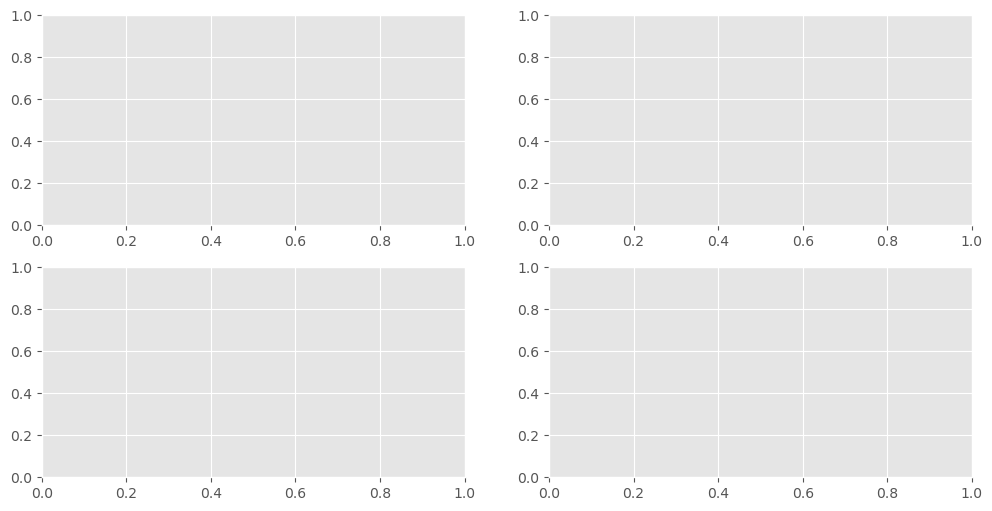

In [26]:
fig, ax = plt.subplots(2, 2)

sns.heatmap(cm_top, annot=True, fmt="d", ax=ax[0,0])
ax[0,0].set_xlabel('Predicted values')
ax[0,0].set_ylabel('Real values')
ax[0,0].set_title('TOP')

sns.heatmap(cm_middle, annot=True, fmt="d", ax=ax[0,1])
ax[0,1].set_xlabel('Predicted values')
ax[0,1].set_ylabel('Real values')
ax[0,1].set_title('MIDDLE')

sns.heatmap(cm_bottom, annot=True, fmt="d", ax=ax[1,0])
ax[1,0].set_xlabel('Predicted values')
ax[1,0].set_ylabel('Real values')
ax[1,0].set_title('BOTTOM')

sns.heatmap(cm_jungle, annot=True, fmt="d", ax=ax[1,1])
ax[1,1].set_xlabel('Predicted values')
ax[1,1].set_ylabel('Real values')
ax[1,1].set_title('JUNGLE')

plt.tight_layout()
plt.show()

### Statystyki zawodników

In [ ]:
data = data.reset_index(drop = True)
data

In [ ]:
data_grouped = data.groupby('summonerName')[['kills', 'assists', 'deaths','win']].agg(['mean', lambda x: x.sum()/x.count()])

new_cols = []
for i, j in data_grouped:
    new_cols.append(str(i) + '_' +str(j))
data_grouped.columns = new_cols
data_grouped = data_grouped[['kills_mean', 'assists_mean', 'deaths_mean', 'win_<lambda_0>']]
data_grouped.reset_index(inplace = True)
data_grouped = round(data_grouped, 2)
data_grouped.columns = ['Summoner Name', 'Average number of kills', 'Average number of assists', 'Average number of deaths', 'Win rate']
data_grouped

In [ ]:
app = JupyterDash()

app.layout = html.Div([
    dcc.Input(id='my-input', value=data_grouped['Summoner Name'].iloc[0], type='text'),
    html.Button(id='submit-button', n_clicks=0, children='Szukaj'),
    html.Div(id='my-output', style={'width': '1000px', 'overflowX': 'auto'}),
    html.Div([
        dcc.Graph(id='my-graph', style={'width': '500px'}),
        dcc.Graph(id='my-pie', style={'width': '500px'})
    ], style={'display': 'flex', 'width': '1000px', 'justifyContent': 'space-between'})
], style={'width': '100%', 'margin': '0 auto'})

@app.callback(
    [Output('my-output', 'children'),
     Output('my-graph', 'figure'),
     Output('my-pie', 'figure')],
    [Input('submit-button', 'n_clicks')],
    [State('my-input', 'value')]
)
def update_output_div(n_clicks, input_value):
    if n_clicks > 0:
        filtered_df = data_grouped[data_grouped['Summoner Name'] == input_value] if input_value in data_grouped['Summoner Name'].values else data_grouped[data_grouped['summonerName'] == 'Annivas']

        table = dash_table.DataTable(
            data=filtered_df.to_dict('records'),
            columns=[{'name': i, 'id': i} for i in filtered_df.columns],
            style_cell={'textAlign': 'left', 'padding': '10px'},
            style_header={
                'backgroundColor': 'powderblue',
                'fontWeight': 'bold'
            },
            style_data_conditional=[
                {
                    'if': {'row_index': 'odd'},
                    'backgroundColor': 'lavender'
                }
            ],
            style_table={'width': '100%', 'maxHeight': '500px', 'overflowY': 'auto'}
        )

        figure = go.Figure(data=[
            go.Bar(name='Average number of kills', x=filtered_df['Summoner Name'], y=filtered_df['Average number of kills'], marker_color='lightsalmon'),
            go.Bar(name='Average number of assists', x=filtered_df['Summoner Name'], y=filtered_df['Average number of assists'], marker_color='palevioletred'),
            go.Bar(name='Average number of deaths', x=filtered_df['Summoner Name'], y=filtered_df['Average number of deaths'], marker_color='cornflowerblue')
        ])
        figure.update_layout(
            autosize=False,
            width=500,
            height=500,
            margin=dict(l=50, r=50, b=100, t=100, pad=4),
            paper_bgcolor="mintcream",
            barmode='group'
        )

        pie = go.Figure(data=[
            go.Pie(labels=['Win', 'Loss'], values=[filtered_df['Win rate'].iloc[0], 1-filtered_df['Win rate'].iloc[0]], hole=0.3, marker_colors=['skyblue', 'peachpuff'])
        ])
        pie.update_layout(
            autosize=False,
            width=500,
            height=500,
            margin=dict(l=50, r=50, b=100, t=100, pad=4),
            paper_bgcolor="mintcream"
        )

        return table, figure, pie
    else:
        return dash.no_update, dash.no_update, dash.no_update

app.run_server(mode="inline", port=8302)


### Zależności między zmiennymi w podziale na pozycje

In [ ]:
data['kda']=round((data['kills']+data['assists'])/data['deaths'],2)
data['timePlayed']=round(data['timePlayed']/60,0)



In [ ]:
app = JupyterDash(__name__)
df=data
column_names = df.columns.tolist()


column_names = [col for col in column_names if col not in ['win', 'championName', 'summonerName','lane','kills','assists','deaths']]
lane_values = df['lane'].unique()

app.layout = html.Div([
    html.Div([
        html.Div([
            dcc.Dropdown(
                id='xaxis-column',
                options=[{'label': i, 'value': i} for i in column_names],
                value='totalDamageDealtToChampions' 
            ),
            dcc.RadioItems(
                id='xaxis-type',
                options=[{'label': i, 'value': i} for i in ['Linear', 'Log']],
                value='Linear',
                inline=True
            )
        ], style={'width': '48%', 'display': 'inline-block'}),

        html.Div([
            dcc.Dropdown(
                id='yaxis-column',
                options=[{'label': i, 'value': i} for i in column_names],
                value='kda'
            ),
            dcc.RadioItems(
                id='yaxis-type',
                options=[{'label': i, 'value': i} for i in ['Linear', 'Log']],
                value='Linear',
                inline=True
            )
        ], style={'width': '48%', 'float': 'right', 'display': 'inline-block'})
    ]),

    dcc.Graph(id='indicator-graphic'),

    dcc.Slider(
        id='number_observ--slider',
        min=df.index.min(),
        max=df.index.max(),
        step=None,
        value=df.index.max()
    )
])

@app.callback(
    Output('indicator-graphic', 'figure'),
    Input('xaxis-column', 'value'),
    Input('yaxis-column', 'value'),
    Input('xaxis-type', 'value'),
    Input('yaxis-type', 'value'),
    Input('number_observ--slider', 'value'))
def update_graph(xaxis_column_name, yaxis_column_name,
                 xaxis_type, yaxis_type,
                 numb_obs_value):
    dff = df.loc[:numb_obs_value]

    fig = px.scatter(data_frame=dff,
                 x=xaxis_column_name,
                 y=yaxis_column_name,
                 color='lane',
                 hover_name='summonerName',
                 template='plotly_dark')

    fig.update_layout(margin={'l': 40, 'b': 40, 't': 10, 'r': 0}, hovermode='closest')

    fig.update_xaxes(title=xaxis_column_name,
                     type='linear' if xaxis_type == 'Linear' else 'log')

    fig.update_yaxes(title=yaxis_column_name,
                     type='linear' if yaxis_type == 'Linear' else 'log')

    return fig


app.run_server(mode='inline', port=8301)